In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import logging

In [2]:
TRAIN_PATH = 'T1'
TEST_PATH = 'Test1'

In [3]:
image_size = (250, 120)
batch_size = 128

# Load training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 11991 files belonging to 8 classes.
Using 9593 files for training.
Found 11991 files belonging to 8 classes.
Using 2398 files for validation.


In [4]:
# Prepare the test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

Found 10578 files belonging to 8 classes.


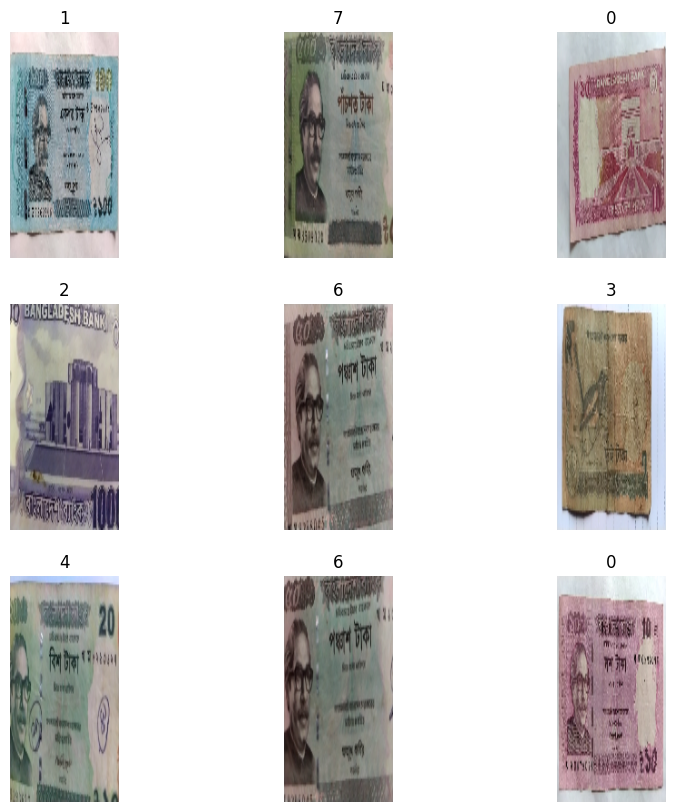

In [5]:
# Display sample images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

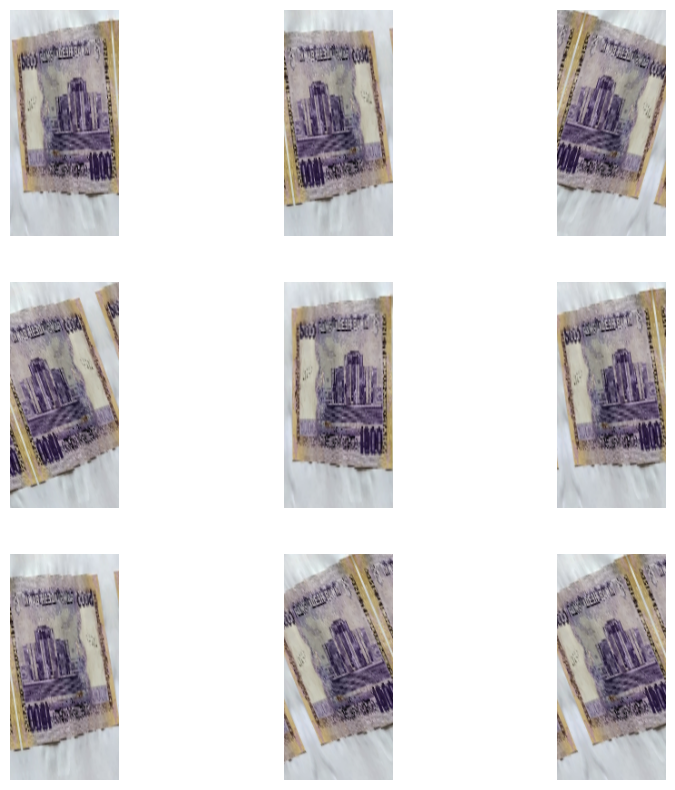

In [6]:
# Suppress TensorFlow warnings
tf.get_logger().setLevel(logging.ERROR)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Apply data augmentation to the training images
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


In [7]:
vgg19 = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(250, 120, 3))
for layer in vgg19.layers:
    layer.trainable = False

# Add custom 
x = keras.layers.Flatten()(vgg19.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(10, activation='softmax')(x)

# Create the full model
full_model = keras.models.Model(inputs=vgg19.input, outputs=predictions)

# Print the model summary
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 60, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 60, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 60, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 30, 128)       0     

In [8]:
# Compile the model
epochs = 6
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
full_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


In [9]:
# Train the model
full_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/6
75/75 [==============================] - 1667s 22s/step - loss: 0.3906 - accuracy: 0.8910 - val_loss: 0.2812 - val_accuracy: 0.9162
Epoch 2/6
75/75 [==============================] - 1137s 15s/step - loss: 0.0235 - accuracy: 0.9924 - val_loss: 0.2587 - val_accuracy: 0.9291
Epoch 3/6
75/75 [==============================] - 1861s 25s/step - loss: 0.0111 - accuracy: 0.9959 - val_loss: 0.2203 - val_accuracy: 0.9462
Epoch 4/6
75/75 [==============================] - 1313s 18s/step - loss: 0.0144 - accuracy: 0.9947 - val_loss: 0.3824 - val_accuracy: 0.9070
Epoch 5/6
75/75 [==============================] - 3431s 46s/step - loss: 0.0317 - accuracy: 0.9904 - val_loss: 0.7745 - val_accuracy: 0.8674
Epoch 6/6
75/75 [==============================] - 1328s 18s/step - loss: 0.0284 - accuracy: 0.9920 - val_loss: 1.0496 - val_accuracy: 0.8641


In [10]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = full_model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
 print(f"Test Accuracy: {test_accuracy}")

83/83 [==============================] - 1005s 12s/step - loss: 1.0888 - accuracy: 0.8657
Test Loss: 1.0888298749923706
Test Accuracy: 0.8656646013259888


3/3 [==============================] - 9s 3s/step


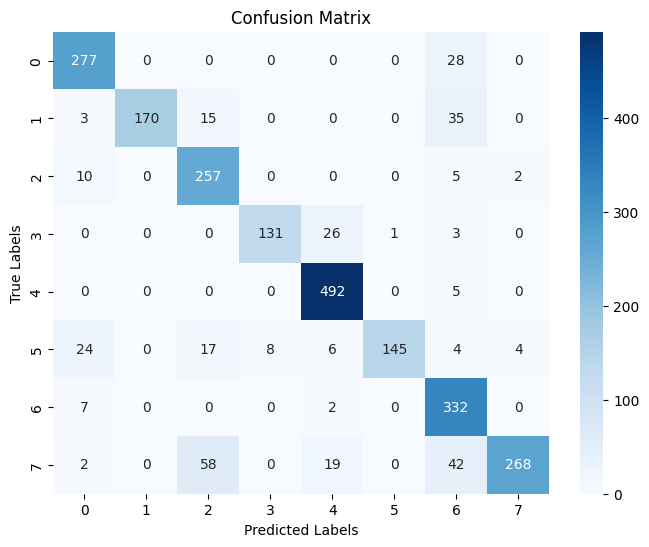

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = full_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  
    y_true.extend(labels.numpy())  
    y_pred.extend(predicted_labels) 

y_true = np.array(y_true)
y_pred = np.array(y_pred)


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


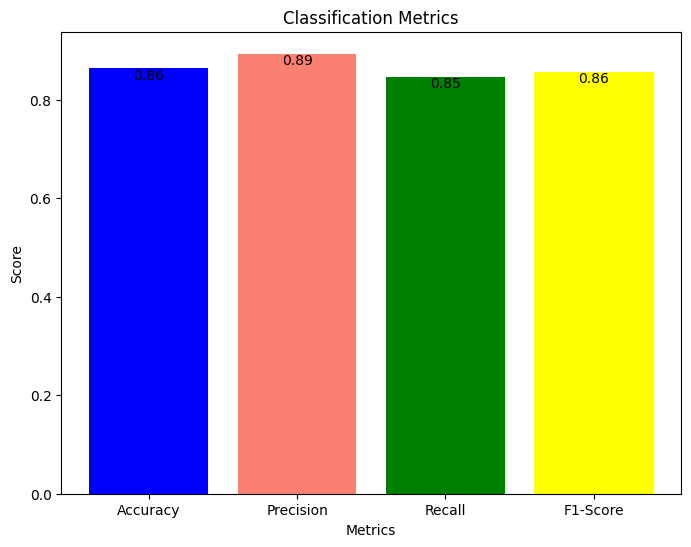

In [27]:

m = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}

plt.figure(figsize=(8, 6))
bars = plt.bar(m.keys(), m.values(), color=['blue', 'salmon', 'green', 'yellow'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='top')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Classification Metrics')
plt.show()
